In [2]:
import io
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from collections import Counter
import pickle as pkl
import string
import random
import pdb
import nltk
from nltk import ngrams
from collections import Counter
from collections import defaultdict

In [3]:
random.seed(152)

nowPath = os.path.abspath('.')
dataPath = nowPath + '//dataSourceCsv'
resPath = nowPath + '//resultsRNN'

all_train = []
all_val = []

In [4]:
def pkl_dumper(objct, file_name):
    with open(file_name, 'wb+') as f:
        pkl.dump(objct, f, protocol=None)

def pkl_loader(file_name):
    with open(file_name, 'rb') as f:
        objct = pkl.load(f, encoding = 'bytes')
    return(objct)

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
def showPlot(points, title):
    fig, ax = plt.subplots()
    lines = {}
    lines['cur'], = ax.plot(range(len(points)), points, label='train loss')
    ax.set_title(title)

In [5]:
allColNames = pkl_loader(dataPath + '//allColNames.p')
colHeader, colSlot = allColNames['columnHeaders'], allColNames['columnSlots']
allTrainTS = pkl_loader(dataPath + '//allTrainTS.p')
allIDs = pkl_loader(dataPath + '//allIDs.p')
allTgts = pkl_loader(dataPath + '//allTgts.p')

In [6]:
## Target for 5 years old: target_3

In [7]:
print('lenTrain:{}, lenTgts:{}'.format(len(allTrainTS), len(allTgts)))

lenTrain:11494, lenTgts:11494


In [8]:
print([item for item in enumerate(colSlot)])

[(0, 'avg0to1'), (1, 'avg1to3'), (2, 'avg3to5'), (3, 'avg5to7'), (4, 'avg7to10'), (5, 'avg10to13'), (6, 'avg13to16'), (7, 'avg16to19'), (8, 'avg19to24'), (9, 'avg24to27'), (10, 'avg27to33'), (11, 'avg33to42'), (12, 'avg42to54'), (13, 'avg54to66'), (14, 'avg66to78')]


In [9]:
newIndex = [i for i, item in enumerate(allTrainTS) if sum(sum(item[:, :9])) != 0.0]

In [10]:
pkl_dumper(newIndex, dataPath + '//allIndNoZero.p')

In [11]:
allTgts = np.array(allTgts)
allTrainTS = np.array(allTrainTS)

In [12]:
allTgts = allTgts[newIndex, 3]
allTrainTS = allTrainTS[newIndex]
allIDs = np.array(allIDs)
allIDs = allIDs[newIndex]

In [ ]:
## Only use 0-24 data, transpose

In [13]:
allTrainTS = allTrainTS[:, :, :9].transpose(0, 2, 1)

In [14]:
def predictor(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    all_predicted = []
    all_label = []
    all_lastHid = []
    for i, (tsdata, lengths, labels) in enumerate(loader):
        tsdata_batch, lengths_batch, label_batch = tsdata.float(), lengths, labels
        lastHid, outputs = model(tsdata_batch, lengths_batch)
        outputs = F.softmax(outputs, dim=1)
        predicted = [x.item() for x in outputs.max(1, keepdim=True)[1]]
        all_predicted += predicted
        all_label += [x.item() for x in labels]
        # print(lastHid.size())
        all_lastHid.extend(lastHid.detach().numpy())
    return (all_predicted, all_label, all_lastHid)

In [15]:
class ObesityDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, tsData, tgt):
        """
        @param data_list: list of character
        @param target_list: list of targets

        """
        self.tsData_list, self.target_list = tsData, tgt
        assert (len(self.tsData_list) == len(self.target_list))

    def __len__(self):
        return len(self.tsData_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        Return: a time series data, len(time series data), label
        """
        #tot_cen = self.interact[method](self.cen_1_list[key], self.cen_2_list[key])
        tsData = self.tsData_list[key]
        label = self.target_list[key]
        return [tsData, len(tsData), label]

def vocab_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    data_list = []
    label_list = []
    length_list = []
    
    data_list, length_list, label_list = zip(*batch)

    # for datum in batch:
    #     label_list.append(datum[2])
    #     length_list.append(datum[1])
    #     data_list.append(datum[0])
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [16]:
class GRU(nn.Module):
    def __init__(self, emb_size, hidden_size, num_layers, num_classes, bidirectional=False):
        # RNN Accepts the following hyperparams:
        # emb_size: Embedding Size
        # hidden_size: Hidden Size of layer in RNN
        # num_layers: number of layers in RNN
        # num_classes: number of output classes
        # vocab_size: vocabulary size
        super(GRU, self).__init__()

        self.num_layers, self.hidden_size = num_layers, hidden_size
        self.bidirectional = bidirectional
        self.rnn = nn.GRU(emb_size, hidden_size, num_layers, batch_first=True, bidirectional=bidirectional)
        self.linear_1 = nn.Linear(hidden_size, hidden_size)
        self.linear_2 = nn.Linear(hidden_size, num_classes)
        
    def init_hidden(self, batch_size):
        # Function initializes the activation of recurrent neural net at timestep 0
        # Needs to be in format (num_layers, batch_size, hidden_size)
        if self.bidirectional == True:
            hidden = torch.randn(self.num_layers*2, batch_size, self.hidden_size)
        else:
            hidden = torch.randn(self.num_layers, batch_size, self.hidden_size)
        return hidden

    def forward(self, tsdata, lengths):
        # reset hidden state
        #print(c1.size())
        batch_size, seq_len, emb_size = tsdata.size()

        self.hidden = self.init_hidden(batch_size)
        tsdata_rnn_out, hidden = self.rnn(tsdata, self.hidden)
        
        hidden, _ = torch.max(hidden, dim=0)
        
        l1_out = self.linear_1(hidden)
        l2_out = self.linear_2(l1_out)
        
        return l1_out, l2_out

In [17]:
splitThreshold = 4000
BATCH_SIZE = 10
train_dataset = ObesityDataset(allTrainTS[:splitThreshold], allTgts[:splitThreshold])
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

val_dataset = ObesityDataset(allTrainTS[splitThreshold:], allTgts[splitThreshold:])
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=True)

In [18]:
all_dataset = ObesityDataset(allTrainTS, allTgts)
all_loader = torch.utils.data.DataLoader(dataset=all_dataset,
                                           batch_size=BATCH_SIZE,
                                           collate_fn=vocab_collate_func,
                                           shuffle=False)

In [19]:
def test_model(loader, model):
    """
    Help function that tests the model's performance on a dataset
    @param: loader - data loader for the dataset to test against
    """
    correct = 0
    total = 0
    model.eval()
    for i, (tsdata, lengths, labels) in enumerate(loader):
        tsdata_batch, lengths_batch, label_batch = tsdata.float(), lengths, labels
        lastHid, outputs = model(tsdata_batch, lengths_batch)
        outputs = F.softmax(outputs, dim=1)
        predicted = outputs.max(1, keepdim=True)[1]
        total += labels.size(0)
        correct += predicted.eq(labels.view_as(predicted)).sum().item()
    return (100 * correct / total)

def model_runner(emb_size=len(colHeader), hidden_size=30, num_layers=1, num_classes=2, bidirectional=True, \
                 learning_rate=2e-4, num_epochs=5, weight_decay=0):
    if 'model' in dir():
        del(model)
        
    model = GRU(emb_size=emb_size, hidden_size=hidden_size, num_layers=num_layers, num_classes=num_classes, \
                bidirectional=bidirectional)

    learning_rate = learning_rate
    num_epochs = num_epochs # number epoch to train

    # Criterion and Optimizer
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # model.cuda()
    # criterion.cuda()

    print('num_parameters:', sum(p.numel() for p in model.parameters()))
    
    # Train the model
    total_step = len(train_loader)

    train_loss_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        for i, (tsdata, lengths, labels) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            # Forward pass
            _, outputs = model(tsdata.float(), lengths)
            #print(outputs.size())
            #print(labels.size())
            loss = criterion(outputs, labels)

            # Backward and optimize
            loss.backward()
            optimizer.step()
            if i > 0 and i % 100 == 0:
                # validate
                val_acc = test_model(val_loader, model)
                val_acc_list.append(val_acc)
                train_loss = loss.item()
                train_loss_list.append(train_loss)
                print('Epoch: [{}/{}], Step: [{}/{}], Train Loss: {}, Validation Acc: {}'.format(
                           epoch+1, num_epochs, i+1, len(train_loader), train_loss, val_acc))
    pkl_dumper(train_loss_list, resPath + '/train_loss_list_' + str(hidden_size) + \
               str(learning_rate) + str(weight_decay) + '.p')
    pkl_dumper(val_acc_list, resPath + '/val_acc_list_' + str(hidden_size) + \
               str(learning_rate) + str(weight_decay) + '.p')
    torch.save(model.state_dict(), resPath + '/model_' + str(hidden_size) + \
               str(learning_rate) + str(weight_decay) + '.model')
    return(model, train_loss_list, val_acc_list)

In [69]:
model1, train_loss_l1, val_acc_l1 = model_runner(learning_rate = 2e-6, num_epochs = 30)

num_parameters: 10892
Epoch: [1/30], Step: [101/400], Train Loss: 0.9010709524154663, Validation Acc: 28.449197860962567
Epoch: [1/30], Step: [201/400], Train Loss: 0.6787683367729187, Validation Acc: 28.342245989304814
Epoch: [1/30], Step: [301/400], Train Loss: 0.7900444269180298, Validation Acc: 30.58823529411765
Epoch: [2/30], Step: [101/400], Train Loss: 0.7412386536598206, Validation Acc: 33.2620320855615
Epoch: [2/30], Step: [201/400], Train Loss: 0.7214570045471191, Validation Acc: 34.43850267379679
Epoch: [2/30], Step: [301/400], Train Loss: 0.7924585938453674, Validation Acc: 35.93582887700535
Epoch: [3/30], Step: [101/400], Train Loss: 0.71490079164505, Validation Acc: 37.64705882352941
Epoch: [3/30], Step: [201/400], Train Loss: 0.7045150399208069, Validation Acc: 40.42780748663102
Epoch: [3/30], Step: [301/400], Train Loss: 0.7342092394828796, Validation Acc: 42.45989304812834
Epoch: [4/30], Step: [101/400], Train Loss: 0.7133797407150269, Validation Acc: 44.91978609625668

Epoch: [29/30], Step: [101/400], Train Loss: 0.36511683464050293, Validation Acc: 84.1711229946524
Epoch: [29/30], Step: [201/400], Train Loss: 0.48883137106895447, Validation Acc: 84.1711229946524
Epoch: [29/30], Step: [301/400], Train Loss: 0.45888596773147583, Validation Acc: 84.1711229946524
Epoch: [30/30], Step: [101/400], Train Loss: 0.388408362865448, Validation Acc: 84.1711229946524
Epoch: [30/30], Step: [201/400], Train Loss: 0.39059823751449585, Validation Acc: 84.1711229946524
Epoch: [30/30], Step: [301/400], Train Loss: 0.43091583251953125, Validation Acc: 84.1711229946524


In [79]:
pred, label, hid = predictor(all_loader, model1)

In [82]:
results = {'pred':pred, 'label':label, 'hid':hid}
pkl_dumper(results, resPath + '//results1118.p')

In [21]:
valAcc = pkl_loader(resPath+ '//val_acc_list_302e-060.p')

In [31]:
valAcc = np.array(valAcc)/100

In [22]:
TrainLoss = pkl_loader(resPath+ '//train_loss_list_302e-060.p')

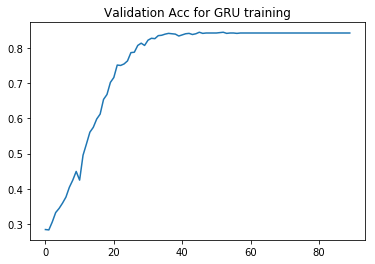

In [33]:
showPlot(valAcc, 'Validation Acc for GRU training')

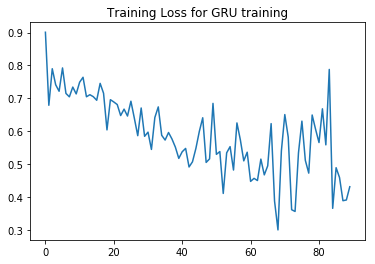

In [28]:
showPlot(TrainLoss, 'Training Loss for GRU training')

In [35]:
train2 = pkl_loader(nowPath + '//resultsS2S' + '//trainS2S1120100_2.p')

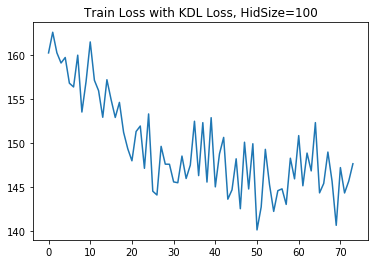

In [37]:
showPlot(train2, 'Train Loss with KDL Loss, HidSize=100')

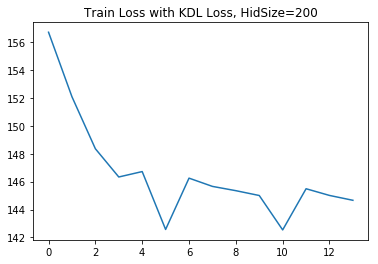

In [45]:
train3 = pkl_loader(nowPath + '//resultsS2S' + '//trainS2S1120.p')
showPlot(train3, 'Train Loss with KDL Loss, HidSize=200')